*Exploratory Data Analysis*

# Understanding the Renderings from Virtual Cameras

In this notebook we visualize the camera poses during training and novel view generation. Finally, we summarize the mathematical model of virtual cameras.

In [17]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, FancyArrow, ArrowStyle
from mpl_toolkits.mplot3d import proj3d
from matplotlib.lines import Line2D
import torch
import itertools

from run_dnerf_helpers import get_rays
from load_deepdeform import load_deepdeform_data, pose_spiral

%load_ext autoreload
%autoreload 2

# Helper function
class Arrow3D(FancyArrowPatch):
    """https://stackoverflow.com/questions/47617952/drawing-a-righthand-coordinate-system-in-mplot3d"""
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load DeepDeform Data

In [18]:
scene_name = "office"
render_pose_type = "spherical"

images, depth_maps, poses, times, render_poses, render_times, hwff, i_split = load_deepdeform_data(f"./data/{scene_name}", True, 1, render_pose_type=render_pose_type)
print('Loaded deepdeform', images.shape, render_poses.shape, hwff)

Loaded deepdeform (404, 480, 360, 3) torch.Size([121, 4, 4]) [480, 360, 422.3722605985754, 598.3607025146484]


tensor([[[ 0.9397,  0.0000, -0.3420,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000],
         [ 0.3420,  0.0000,  0.9397,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9417,  0.0000, -0.3365,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000],
         [ 0.3365,  0.0000,  0.9417,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9436,  0.0000, -0.3311,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000],
         [ 0.3311,  0.0000,  0.9436,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        ...,

        [[ 0.9436,  0.0000,  0.3311,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000],
         [-0.3311,  0.0000,  0.9436,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9417,  0.0000,  0.3365,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000],
         [-0.3365,  0.0000,  0.9417,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9397,  0.0000,  0.3420,

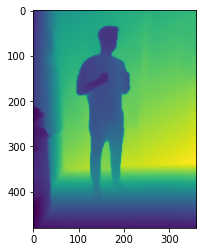

In [22]:
plt.imshow(images[0])
plt.imshow(depth_maps[0])
print(render_poses)

Get some rays for the first pose (code in `from run_dnerf_helpers import get_rays`):

In [20]:
render_pose = render_poses[0]
print("First novel camera pose to be rendered:\n", render_pose)
print("Camera pose of the training images:\n", poses[0])

# Implemented in get_rays(H, W, focal, c2w) function

c2w = render_pose[:3]
H, W, focal_x, focal_y = hwff

# Create coordinates for each pixel in the camera coordinate system
i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H), indexing='ij')      # shape [240, 320], [240, 320]
i = i.t()           # pixel coordinates in X-dir
j = j.t()           # in Y-dir
# The ray directions in the camera coordinate system. 
# Center the X- and Y-coordinates to the image center and scale by focal length. The rays go in the negative Z direction.
dirs = torch.stack([(i-W*.5)/focal_x, -(j-H*.5)/focal_y, -torch.ones_like(i)], -1)                                          # shape [240, 320, 3]

# Rotate ray directions from camera frame to the world frame
rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
# Translate camera frame's origin to the world frame. It is the origin of all rays.
rays_o = c2w[:3,-1].expand(rays_d.shape)

print("Ray directions shape:", rays_d.shape)
print("Ray origins shape:", rays_o.shape)
print("Ray direction for pixel [0,0] is", rays_d[0,0].tolist(), "with origin at", rays_o[0,0].tolist())

First novel camera pose to be rendered:
 tensor([[ 0.9397,  0.0000, -0.3420,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.3420,  0.0000,  0.9397,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
Camera pose of the training images:
 [[-1.0000000e+00  5.6185043e-09 -4.4614321e-09  0.0000000e+00]
 [-5.6185043e-09 -1.0000000e+00  1.9931988e-10  0.0000000e+00]
 [-4.4614321e-09  1.9931991e-10  1.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
Ray directions shape: torch.Size([480, 360, 3])
Ray origins shape: torch.Size([480, 360, 3])
Ray direction for pixel [0,0] is [-0.0584433376789093, 0.40109583735466003, -1.085449457168579] with origin at [0.0, 0.0, 0.0]


Plot the coordinate frames and the rays.

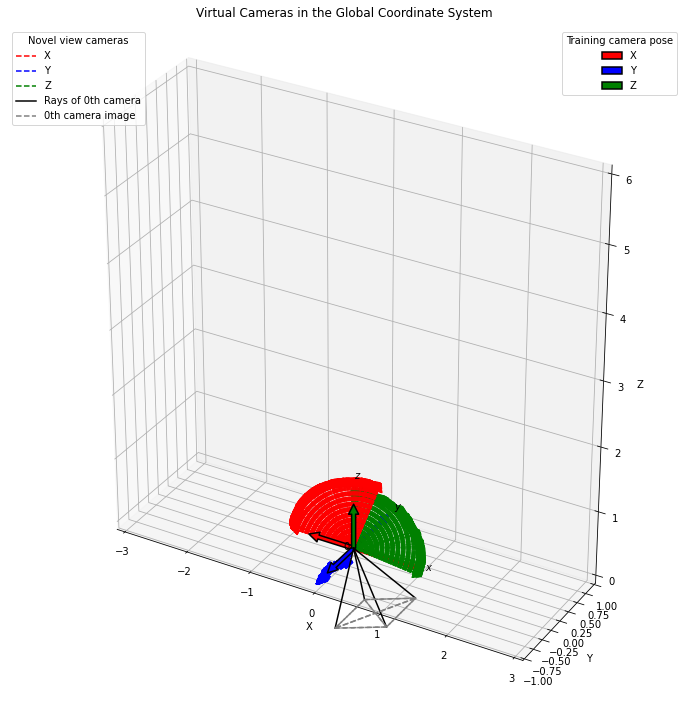

In [21]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, projection='3d')

xlim = [-3, 3]
ylim = [-1, 1]
zlim = [0, 6]
#xlim = [-1.5, 1.5]
#ylim = [-1.5, 1.5]
#zlim = [0, 6]
ax1.set_xlabel('X')
ax1.set_xlim(*xlim)
ax1.set_ylabel('Y')
ax1.set_ylim(*ylim)
ax1.set_zlabel('Z')
ax1.set_zlim(*zlim)
ax1.set_box_aspect((xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]))       # -> length of 1 in each dimension is visually the equal

# The world coordinate system
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='simple', shrinkA=0, shrinkB=0)
ax1.add_artist(Arrow3D([0, 1], [0, 0], [0, 0], **arrow_prop_dict, color='r'))
ax1.add_artist(Arrow3D([0, 0], [0, 1], [0, 0], **arrow_prop_dict, color='b'))
ax1.add_artist(Arrow3D([0, 0], [0, 0], [0, 1], **arrow_prop_dict, color='g'))
ax1.text(-.1, -.1, 0.0, r'$0$')
ax1.text(1.1, 0, 0, r'$x$')
ax1.text(0, 1.1, 0, r'$y$')
ax1.text(0, 0, 1.1, r'$z$')

def draw_transformed(c2w, ax, axes_len=1.0, edgecolor=None, **kwargs):
    """Draw the camera coordinate frame. Camera-to-world transformation."""
    # R = torch.Tensor(np.array([[-1,0,0],[0,0,1],[0,1,0]])).T @ c2w[:3, :3]
    R = c2w[:3, :3]
    # new_o = torch.Tensor(np.array([[-1,0,0],[0,0,1],[0,1,0]])).T @ c2w[:3, 3]
    new_o = c2w[:3, 3]
    new_x = R @ np.array([axes_len, 0, 0]) + new_o
    new_y = R @ np.array([0, axes_len, 0]) + new_o
    new_z = R @ np.array([0, 0, axes_len]) + new_o
    arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', shrinkA=0, shrinkB=0, fill=True)
    arrow_prop_dict.update(**kwargs)
    arrx = ax.add_artist(Arrow3D([new_o[0], new_x[0]], [new_o[1], new_x[1]], [new_o[2], new_x[2]], **arrow_prop_dict, facecolor='r', edgecolor=edgecolor if edgecolor else "r"))
    arry = ax.add_artist(Arrow3D([new_o[0], new_y[0]], [new_o[1], new_y[1]], [new_o[2], new_y[2]], **arrow_prop_dict, facecolor='b', edgecolor=edgecolor if edgecolor else "b"))
    arrz = ax.add_artist(Arrow3D([new_o[0], new_z[0]], [new_o[1], new_z[1]], [new_o[2], new_z[2]], **arrow_prop_dict, facecolor='g', edgecolor=edgecolor if edgecolor else "g"))
    return arrx, arry, arrz, new_o

def draw_cam(rays_o, rays_d, ax):
    H, W, _ = rays_d.shape
    ps = []
    # plot camera rays
    for iy, ix in [[0, 0], [H-1, 0], [0, W-1], [H-1, W-1]]:
        # o = torch.Tensor(np.array([[-1,0,0],[0,0,1],[0,1,0]])).T @ rays_o[iy, ix]
        # d = torch.Tensor(np.array([[-1,0,0],[0,0,1],[0,1,0]])).T @ rays_d[iy, ix]
        o = rays_o[iy, ix]
        d = rays_d[iy, ix]
        p = o + d
        ax.plot([o[0], p[0]], [o[1], p[1]], [o[2], p[2]], color="black")
        ps.append(p)
    # plot camera frame
    for p1, p2 in list(itertools.permutations(ps, 2)):
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color="grey", ls="--")

# Draw novel camera coordinate frames
new_os = []
for pose in render_poses[::]:
    rcx, rcy, rcz, new_o = draw_transformed(pose, ax1, linestyle="--")
    new_os.append(new_o)
ax1.plot([n[0] for n in new_os], [n[1] for n in new_os], [n[2] for n in new_os])

# Draw the training camera coordinate frame
tcx, tcy, tcz, _ = draw_transformed(poses[0], ax1, arrowstyle='simple', axes_len=0.7, linewidth=1.5, mutation_scale=20, edgecolor="black")

lgnd1 = plt.legend(handles=[tcx, tcy, tcz], 
           labels=["X", "Y", "Z"], 
           title="Training camera pose", loc=1)
plt.legend(handles=[Line2D([0], [0], color='r', ls="--"), 
                    Line2D([0], [0], color='b', ls="--"), 
                    Line2D([0], [0], color='g', ls="--"), 
                    Line2D([0], [0], color='black', ls="-"),
                    Line2D([0], [0], color='grey', ls="--")], 
           labels=["X", "Y", "Z", "Rays of 0th camera", "0th camera image"], 
           title="Novel view cameras", loc=2)
plt.gca().add_artist(lgnd1)


draw_cam(rays_o, rays_d, ax1)       # rays_o and rays_d are already in world-coordinates

fig.suptitle("Virtual Cameras in the Global Coordinate System", )
fig.tight_layout()

plt.show()

## Theory: The Virtual Camera Model

A camera is a mapping between the 3D world and a 2D image:
$$[X,Y,Z]^T\rightarrow[x,y]^T$$
where $\mathbf{X}=[X,Y,Z]^T$ is a 3D world point and $\mathbf{x}=[x,y]^T$ is the corresponding 2D point on the image. This perspective projection is modeled by the ideal pinhole camera with the mathematical relationship given by the camera matrix $\mathbf{P}\in\R^{3\times4}$:

$$
\begin{aligned}
    P &= \overbrace{K}^{\text{Intrinsic Matrix}} \times \overbrace{[R \mid \mathbf{t}]}^{\text{Extrinsic Matrix}}\\
    &=\overbrace{
        \underbrace{\left(\begin{array}{ccc}1 & 0 & x_{0} \\ 0 & 1 & y_{0} \\ 0 & 0 & 1\end{array}\right)}_{\text{ 2D Translation }} \times \underbrace{\left(\begin{array}{ccc}f_{x} & 0 & 0 \\ 0 & f_{y} & 0 \\ 0 & 0 & 1\end{array}\right)}_{\text {2D Scaling }} \times \underbrace{\left(\begin{array}{ccc}1 & s/f_{x} & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1\end{array}\right)}_{\text {2D Shear }}
    }^{\text{Intrinsic Matrix}} \times
    \overbrace{
        \underbrace{(I \mid \mathbf{t})}_{\text {3D Translation }} \times 
        \underbrace{\left(\begin{array}{c|c}R & 0 \\ \hline 0 & 1\end{array}\right)}_{\text {3D Rotation }}
    }^{\text{Extrinsic Matrix}}
\end{aligned}
$$

where $f_x$ and $f_y$ are the focal lengths (in pixels) and $x_0$ and $y_0$ are the principal point offset, i.e. the location of the principal point ("the pinhole") relative to the film's origin. The axis skew $s$ causes shear distortion in the projected image and is usually zero. In a true pinhole camera, both $f_x$ and $f_y$ have the same value, but in practive they can differ due to flaws in the camera's optics or sensor. The resulting image has non-square pixels. Finally, the extrinsic matrix rotates and translates the camera.

The image on the pinhole camera's film depicts a mirrored version of reality. Using a "virtual image" instead of the film fixes this. The virtual image has the same properties as the film image, but unlike the true image, the virtual image appears in front of the camera, and the projected image is unflipped, as shown in the following figure.

<figure>
    <div style="text-align: center;">
        <img src="./media/intrinsic-frustum-no-box.png" width="200"/>
        <p align="center">
            <b>The pinhole camera's flipped projection and the unflipped virtual camera's image.</b>
        </p>
    </div>
</figure>

Removing the true image leaves only the "viewing frustum" representation of the pinhole camera. The pinhole has been replaced by the tip of the pyramid-shaped "visibility cone", and the film is now represented by the virtual image plane.

#### References 
- [Dissecting the Camera Matrix, Part 3: The Intrinsic Matrix](https://ksimek.github.io/2013/08/13/intrinsic/)
- [16-385 Computer Vision (Kris Kitani) - Carnegie Mellon University](https://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf)